In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
sns.set_style('whitegrid')

In [3]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [4]:
booking_df = pd.read_pickle('booking_cleaned.pkl')

In [5]:
booking_df = pd.read_pickle('booking_notNan.pkl')

In [6]:
booking_df.to_csv('airbnb_booking.csv')

In [35]:
num_booker = booking_df[booking_df['booker'] == 1].shape[0]
num_non_booker = booking_df[booking_df['booker'] == 0].shape[0]
print(f'There is a total of {num_booker} positive class and {num_non_booker} negative class')
print(f'The ratio of negative:positive is {round(num_non_booker/num_booker, 4)}')

There is a total of 39452 positive class and 111470 negative class
The ratio of negative:positive is 2.8255


In [36]:
booking_df['signup_flow'] = [str(x) for x in booking_df.signup_flow]

#### Let's define our features and targets

In [37]:
booking_df_dummies = pd.get_dummies(booking_df, drop_first = True)

In [38]:
X = booking_df_dummies.drop('booker', 1)
y = booking_df_dummies.booker

#### Train/Test Split

In [101]:
# 60-20-20 train-val-test split (stratify = target for balance positive examples)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

#### Balance out the classes using ADASYN 

In [40]:
from imblearn.over_sampling import ADASYN

X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_sample(X_train,y_train)

In [30]:
print(f'train set, positive class: {Counter(y_adasyn_train)[0]}, negative class: {Counter(y_adasyn_train)[1]}')

train set, positive class: 166862, negative class: 173117


#### Create a helper function to calculate the score of a model

In [18]:
def score(X_train, y_train, X_val, y_val, model, threshold = 0.5):
    
#     print("Training: {:6.2f}%".format(100*model.score(X_train, y_train)))
#     print("Test set: {:6.2f}%".format(100*model.score(X_val, y_val)))
    
    logit_confusion = confusion_matrix(y_val, model.predict(X_val))
#     print("Precision: {:6.4f}, Recall: {:6.4f}".format(precision_score(y_val, logit.predict(X_val)), 
#                                                      recall_score(y_val, logit.predict(X_val))))
    
    f1score = f1_score(y_val, model.predict(X_val))
    
    y_train_pred = (model.predict_proba(X_train)[:,1] > threshold)
    y_val_pred = (model.predict_proba(X_val)[:,1] > threshold)

    
    scores = {'Training': [100*model.score(X_train,y_train),precision_score(y_train, y_train_pred),
                         recall_score(y_train, y_train_pred), f1_score(y_train, y_train_pred)],
              
            'Testing': [100*model.score(X_val,y_val),precision_score(y_val, y_val_pred),
                         recall_score(y_val, y_val_pred), f1_score(y_val, y_val_pred)]}
    
    score_df = pd.DataFrame(scores, index = ['Accuracy', 'Precision', 'Recall', 'F1_Score'])
    
    return score_df

#### Create a helper function to calculate the optimal threshold for the model

In [19]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 
def plot_threshold_curve(X_val, y_val, model, title):
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, model.predict_proba(X_val)[:,1]);

    plt.figure(dpi=80);
    plt.plot(threshold_curve, precision_curve[1:],label='precision');
    plt.plot(threshold_curve, recall_curve[1:], label='recall');
    plt.legend(loc='lower left');
    plt.xlabel('Threshold (above this probability, label as positive)');
    plt.title(f'Precision and Recall Curves using {title}');
    
    return plt;

#### Create helper function to calculate the ROC and calculate the ROC/AUC score

In [20]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

def plot_ROC(X_val, y_val, model):

    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:,1]);

    plt.plot(fpr, tpr,lw=2);
    plt.plot([0,1],[0,1],c='violet',ls='--');
    plt.xlim([-0.05,1.05]);
    plt.ylim([-0.05,1.05]);


    plt.xlabel('False positive rate');
    plt.ylabel('True positive rate');
    plt.title('ROC Curve');
    
    print("ROC AUC score = ", roc_auc_score(y_val, model.predict_proba(X_val)[:,1]))
    
    return roc_auc_score(y_val, model.predict_proba(X_val)[:,1])

### Logistic Regression

In [12]:
logit_params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                             'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                             'max_iter': [100, 200, 300, 400, 500, 600]}

In [21]:
folds = 3

# model = LogisticRegression(random_state=42, n_jobs = 1, **param)
iterations = 25

#run the CV
from datetime import datetime
import random
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import ParameterGrid

# Initiate KFolds - stratify ensures even distribution of target class in each fold
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state = 42)

# initial model and score collected in each fold
model_clf_model = []
model_clf_aucs = []

# divide the training and test set into n_splits

X_train, y_train = np.array(X_train), np.array(y_train)

for train_ind, val_ind in kf.split(X_train,y_train):

    X_train_, y_train_ = X_train[train_ind], y_train[train_ind]
    X_val_, y_val_ = X_train[val_ind], y_train[val_ind] 

    # Use adasyn to oversample the training set and leave validation set alone
    X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_sample(X_train_,y_train_)

    # a dictionary of parameters to test the model on
    params = logit_params

    # Make the model into a list of parameters to test on
    param_list = list(ParameterGrid(logit_params))

    # Initials a dictionary of each model and score for each param in param_list
    logit_model_aucs = {}

    # run the model for each parameter picking randomly for a number of iterations
    for param in random.sample(param_list, iterations):
        
        start_time = datetime.now()
        # instantiate a model passing in param as arguments
        model_adasyn = LogisticRegression(random_state=42, n_jobs = -1, **param, )
        # fit the model using oversampled training data 
        model_adasyn.fit(X_adasyn_train, y_adasyn_train)
        end_time = datetime.now()
        duration = end_time - start_time

        # append the model and its AUC score into model_aucs which is a dictionary
        auc = roc_auc_score(y_val_, model_adasyn.predict_proba(X_val_)[:,1])
        logit_model_aucs.update({model_adasyn: auc})
        
        print(auc, param, duration)

    # append this model for to a list
    model_clf_model.append(max(logit_model_aucs, key=logit_model_aucs.get))

    # append this auc score for the model to a list
    model_clf_aucs.append(logit_model_aucs[max(logit_model_aucs, key=logit_model_aucs.get)])


0.6065761918856973 {'C': 0.3, 'max_iter': 500, 'solver': 'saga'} 0:00:35.049361


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6063501065658524 {'C': 0.8, 'max_iter': 400, 'solver': 'liblinear'} 0:00:02.565526


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6061663936657194 {'C': 1, 'max_iter': 100, 'solver': 'sag'} 0:00:18.055775


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6072622135709818 {'C': 0.2, 'max_iter': 200, 'solver': 'liblinear'} 0:00:01.915910
0.6076390159110714 {'C': 0.1, 'max_iter': 400, 'solver': 'lbfgs'} 0:01:22.092639


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6064637196853446 {'C': 0.6, 'max_iter': 400, 'solver': 'liblinear'} 0:00:02.512412


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.606541837938253 {'C': 0.5, 'max_iter': 400, 'solver': 'liblinear'} 0:00:02.411602
0.6067593298764979 {'C': 1, 'max_iter': 400, 'solver': 'lbfgs'} 0:01:23.790959


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6064637196853446 {'C': 0.6, 'max_iter': 100, 'solver': 'liblinear'} 0:00:02.492716
0.6061915686428011 {'C': 0.9, 'max_iter': 600, 'solver': 'sag'} 0:00:44.068157
0.606216519351846 {'C': 0.8, 'max_iter': 300, 'solver': 'newton-cg'} 0:01:20.289526
0.606850496613356 {'C': 0.2, 'max_iter': 600, 'solver': 'sag'} 0:00:15.054920
0.6020577231360928 {'C': 0.5, 'max_iter': 100, 'solver': 'lbfgs'} 0:00:20.205636
0.6063501047859474 {'C': 0.5, 'max_iter': 600, 'solver': 'saga'} 0:00:49.660771
0.5897259126165475 {'C': 0.4, 'max_iter': 100, 'solver': 'lbfgs'} 0:00:20.728187
0.6065772242306285 {'C': 0.3, 'max_iter': 100, 'solver': 'saga'} 0:00:18.862558


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.606851092881549 {'C': 0.2, 'max_iter': 500, 'solver': 'newton-cg'} 0:01:01.702217
0.6040874556632994 {'C': 0.9, 'max_iter': 100, 'solver': 'lbfgs'} 0:00:20.145259
0.6061779879672402 {'C': 0.8, 'max_iter': 500, 'solver': 'lbfgs'} 0:01:45.909518
0.6065775517331584 {'C': 0.3, 'max_iter': 100, 'solver': 'newton-cg'} 0:01:07.453052
0.606216519351846 {'C': 0.8, 'max_iter': 500, 'solver': 'newton-cg'} 0:01:20.527098
0.6062161544713099 {'C': 0.8, 'max_iter': 600, 'solver': 'saga'} 0:01:06.400537


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6072622135709818 {'C': 0.2, 'max_iter': 300, 'solver': 'liblinear'} 0:00:01.886851
0.6052149080411786 {'C': 0.4, 'max_iter': 300, 'solver': 'lbfgs'} 0:01:01.726471


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6072622135709818 {'C': 0.2, 'max_iter': 100, 'solver': 'liblinear'} 0:00:01.903603
0.6032172850876717 {'C': 0.7, 'max_iter': 300, 'solver': 'newton-cg'} 0:01:42.445254
0.6036130523391958 {'C': 0.3, 'max_iter': 300, 'solver': 'saga'} 0:00:35.948685
0.6033398169827231 {'C': 0.5, 'max_iter': 500, 'solver': 'sag'} 0:00:29.440981
0.6031457115794822 {'C': 0.4, 'max_iter': 500, 'solver': 'lbfgs'} 0:01:45.170439
0.6031478049550698 {'C': 0.9, 'max_iter': 200, 'solver': 'newton-cg'} 0:01:39.800516


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6032766436781036 {'C': 0.9, 'max_iter': 200, 'solver': 'liblinear'} 0:00:02.638059


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6032655163900094 {'C': 0.6, 'max_iter': 100, 'solver': 'sag'} 0:00:18.091067
0.6034425258926173 {'C': 0.6, 'max_iter': 300, 'solver': 'liblinear'} 0:00:02.602584


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6036090631770428 {'C': 0.3, 'max_iter': 100, 'solver': 'saga'} 0:00:19.246740
0.6043643463247819 {'C': 0.2, 'max_iter': 100, 'solver': 'liblinear'} 0:00:01.981123
0.6031796114474179 {'C': 0.8, 'max_iter': 600, 'solver': 'sag'} 0:00:40.461325
0.6032687614781866 {'C': 0.6, 'max_iter': 400, 'solver': 'sag'} 0:00:33.484938
0.6047716947851273 {'C': 0.1, 'max_iter': 400, 'solver': 'saga'} 0:00:17.751539
0.603213488174297 {'C': 1, 'max_iter': 600, 'solver': 'lbfgs'} 0:02:06.204931
0.6032165997563781 {'C': 0.7, 'max_iter': 200, 'solver': 'sag'} 0:00:36.218248


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6031234765841877 {'C': 1, 'max_iter': 300, 'solver': 'newton-cg'} 0:01:35.573099


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6054670354757739 {'C': 0.1, 'max_iter': 300, 'solver': 'liblinear'} 0:00:01.727794
0.6034509599177318 {'C': 0.4, 'max_iter': 100, 'solver': 'newton-cg'} 0:01:14.793089
0.6031805815917166 {'C': 0.8, 'max_iter': 100, 'solver': 'newton-cg'} 0:01:32.597346
0.6031222038260711 {'C': 1, 'max_iter': 400, 'solver': 'saga'} 0:01:15.814798
0.604771819390817 {'C': 0.1, 'max_iter': 500, 'solver': 'sag'} 0:00:10.016258


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6036919348611296 {'C': 0.4, 'max_iter': 600, 'solver': 'liblinear'} 0:00:02.724891
0.6036137625916275 {'C': 0.3, 'max_iter': 200, 'solver': 'sag'} 0:00:20.474111
0.6070960430395174 {'C': 0.5, 'max_iter': 200, 'solver': 'lbfgs'} 0:00:43.090890


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6031164648440177 {'C': 1, 'max_iter': 200, 'solver': 'saga'} 0:00:38.691094
0.6055684809581282 {'C': 0.6, 'max_iter': 100, 'solver': 'saga'} 0:00:19.464340


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6065401290938155 {'C': 0.3, 'max_iter': 300, 'solver': 'lbfgs'} 0:01:04.591493


/Users/bentleyou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.6063236370562622 {'C': 0.3, 'max_iter': 300, 'solver': 'liblinear'} 0:00:02.427757
0.6063657847985445 {'C': 0.2, 'max_iter': 100, 'solver': 'newton-cg'} 0:01:04.115400
0.6055008829361901 {'C': 0.7, 'max_iter': 500, 'solver': 'sag'} 0:00:37.961554


KeyboardInterrupt: 

In [41]:
# Using ADASYN data
# std_adasyn = StandardScaler()
# std_adasyn.fit(X_adasyn_train)
# X_adasyn_train_scaled = std_adasyn.transform(X_adasyn_train)
# X_val_adasyn_scaled = std_adasyn.transform(X_val)

logit_adasyn =  LogisticRegression(C=0.9, class_weight='balanced', dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=300,
                    multi_class='warn', n_jobs=1, penalty='l2', random_state=42,
                    solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)
logit_adasyn.fit(X_adasyn_train, y_adasyn_train);

              precision    recall  f1-score   support

           0       0.82      0.60      0.70     27868
           1       0.36      0.63      0.46      9863

    accuracy                           0.61     37731
   macro avg       0.59      0.62      0.58     37731
weighted avg       0.70      0.61      0.63     37731

ROC AUC score =  0.6676457055459131


0.6676457055459131

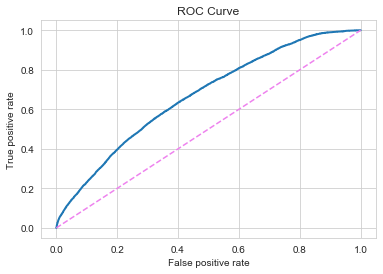

In [42]:
print(classification_report(y_val, logit_adasyn.predict(X_val)))
plot_ROC(X_val, y_val, logit_adasyn)

#### Using adasyn Logistic Regression

<module 'matplotlib.pyplot' from '/Users/bentleyou/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

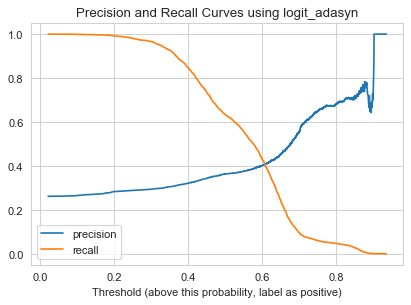

In [281]:
plot_threshold_curve(X_val, y_val, logit_adasyn, 'logit_adasyn')

#### RandomForest using adasyn and GridSearchCV

In [340]:
rf_params = {'max_depth': [8,9,10,11],
            'min_samples_leaf': [2, 4, 6, 8],
            'min_samples_split': [0,1,2,3],
            'n_estimators': [200, 300, 400, 500, 600],
            'min_samples_split': [2, 3, 4, 5, 6],
            'max_features' :['auto', 'sqrt']}

In [43]:
from sklearn.ensemble import RandomForestClassifier
rf_adasyn = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=8, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=2, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=400,
                        n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                        warm_start=False)
rf_adasyn_clf = rf_adasyn.fit(X_adasyn_train, y_adasyn_train)

              precision    recall  f1-score   support

           0       0.81      0.66      0.73     27868
           1       0.37      0.56      0.44      9863

    accuracy                           0.63     37731
   macro avg       0.59      0.61      0.59     37731
weighted avg       0.69      0.63      0.65     37731

ROC AUC score =  0.6614680000752668


0.6614680000752668

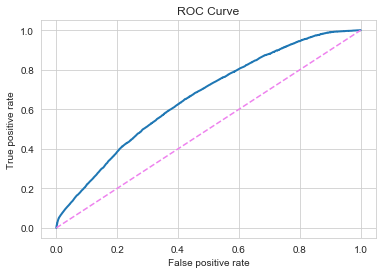

In [44]:
print(classification_report(y_val, rf_adasyn_clf.predict(X_val)))
plot_ROC(X_val, y_val, rf_adasyn_clf)

### Using XGBoost Classifer

In [23]:
from xgboost import XGBClassifier

#### XGBoost on adasyn Parameter Tuning

In [354]:
folds = 3
parameters = xgboost_params = {'max_depth': [6, 7, 8, 9, 10, 11, 12],
                  'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200],
                  'learning_rate' : [0.001, 0.01, 0.1],
                  'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                  'gamma': [0, 2, 4, 6, 8, 10]}
model = XGBClassifier(random_state=42, n_jobs = 1, **param)
iterations = 25

#run the CV
from datetime import datetime
import random
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import ParameterGrid

# Initiate KFolds - stratify ensures even distribution of target class in each fold
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state = 42)

# initial model and score collected in each fold
model_clf_model = []
model_clf_aucs = []

# divide the training and test set into n_splits

X_train, y_train = np.array(X_train), np.array(y_train)

for train_ind, val_ind in kf.split(X_train,y_train):

    X_train_, y_train_ = X_train[train_ind], y_train[train_ind]
    X_val_, y_val_ = X_train[val_ind], y_train[val_ind] 

    # Use adasyn to oversample the training set and leave validation set alone
    X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_sample(X_train_,y_train_)

    # a dictionary of parameters to test the model on
    params = parameters

    # Make the model into a list of parameters to test on
    param_list = list(ParameterGrid(params))

    # Initials a dictionary of each model and score for each param in param_list
    xgb_model_aucs = {}

    # run the model for each parameter picking randomly for a number of iterations
    for param in random.sample(param_list, iterations):
        
        start_time = datetime.now()
        # instantiate a model passing in param as arguments
        model_adasyn = XGBClassifier(random_state=101, n_jobs = -1, **param, max_delta_step=1)
        # fit the model using oversampled training data 
        model_adasyn.fit(X_adasyn_train, y_adasyn_train)
        end_time = datetime.now()
        duration = end_time - start_time

        # append the model and its AUC score into model_aucs which is a dictionary
        auc = roc_auc_score(y_val_, model_adasyn.predict_proba(X_val_)[:,1])
        xgb_model_aucs.update({model_adasyn: auc})
        
        print(auc, param, duration)

    # append this model for to a list
    model_clf_model.append(max(model_aucs, key=model_aucs.get))

    # append this auc score for the model to a list
    model_clf_aucs.append(model_aucs[max(model_aucs, key=model_aucs.get)])


0.6639173104502546 {'colsample_bytree': 0.5, 'gamma': 6, 'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100} 0:00:26.370306
0.6589820934248384 {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.001, 'max_depth': 6, 'n_estimators': 400} 0:01:48.458304
0.6568707617615157 {'colsample_bytree': 0.9, 'gamma': 8, 'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 100} 0:00:31.298917
0.6492765452523672 {'colsample_bytree': 0.3, 'gamma': 8, 'learning_rate': 0.001, 'max_depth': 12, 'n_estimators': 100} 0:00:23.303696
0.6636552769664296 {'colsample_bytree': 0.5, 'gamma': 6, 'learning_rate': 0.001, 'max_depth': 8, 'n_estimators': 700} 0:02:42.046205
0.6700241072210396 {'colsample_bytree': 0.6, 'gamma': 4, 'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 700} 0:04:20.134927
0.6647804630407679 {'colsample_bytree': 0.9, 'gamma': 6, 'learning_rate': 0.001, 'max_depth': 9, 'n_estimators': 800} 0:05:09.718312
0.6737537094638374 {'colsample_bytree': 0.5, 'gamma': 8, 'learning_ra

In [46]:
xgb_param = {'colsample_bytree': 0.5, 'gamma': 8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 400}
XGBoost_adasyn = XGBClassifier(random_state = 101, **xgb_param, n_jobs = -1 )
XGBoost_adasyn_clf = XGBoost_adasyn.fit(X_adasyn_train, y_adasyn_train)

              precision    recall  f1-score   support

           0       0.75      0.97      0.85     27868
           1       0.54      0.11      0.18      9863

    accuracy                           0.74     37731
   macro avg       0.65      0.54      0.52     37731
weighted avg       0.70      0.74      0.67     37731

ROC AUC score =  0.6755186393769756


0.6755186393769756

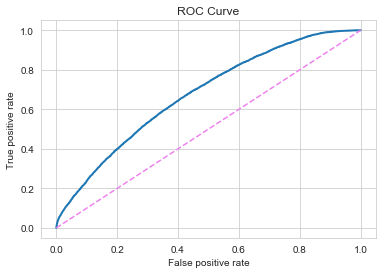

In [47]:
print(classification_report(y_val, XGBoost_adasyn_clf.predict(X_val.values)))
plot_ROC(X_val.values, y_val, XGBoost_adasyn_clf)

#### Using LightGBM on adasyn

In [48]:
import lightgbm as lgb

In [27]:
parameters = lgb_params = {'max_depth': [-1, 7, 8, 9, 10],
                  'num_leaves': [31, 40, 50, 60],
                  'min_child_sample': [20, 50, 100, 200, 300, 400, 500, 600],
                  'learning_rate' : [0.001, 0.01, 0.1, 1],
                  'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
                  'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                  'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
                  }

In [28]:
folds = 5

model = lgb.LGBMClassifier(random_state=101, n_jobs = -1)
iterations = 100

#run the CV
from datetime import datetime
import random
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import ParameterGrid

# Initiate KFolds - stratify ensures even distribution of target class in each fold
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state = 42)

# initial model and score collected in each fold
model_clf_model = []
model_clf_aucs = []

# divide the training and test set into n_splits

X_train, y_train = np.array(X_train), np.array(y_train)

for train_ind, val_ind in kf.split(X_train,y_train):

    X_train_, y_train_ = X_train[train_ind], y_train[train_ind]
    X_val_, y_val_ = X_train[val_ind], y_train[val_ind] 

    # Use adasyn to oversample the training set and leave validation set alone
    X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_sample(X_train_,y_train_)

    # a dictionary of parameters to test the model on
    params = parameters

    # Make the model into a list of parameters to test on
    param_list = list(ParameterGrid(params))

    # Initials a dictionary of each model and score for each param in param_list
    lgb_model_aucs = {}

    # run the model for each parameter picking randomly for a number of iterations
    for param in random.sample(param_list, iterations):
        
        start_time = datetime.now()
        # instantiate a model passing in param as arguments
        model_adasyn = lgb.LGBMClassifier(random_state=90, n_jobs = -1, **param)
        # fit the model using oversampled training data 
        model_adasyn.fit(X_adasyn_train, y_adasyn_train, eval_metric='auc',  
                  eval_set=[(X_val_, y_val_)], early_stopping_rounds=300, verbose = False)

        end_time = datetime.now()
        duration = end_time - start_time

        # append the model and its AUC score into model_aucs which is a dictionary
        auc = roc_auc_score(y_val_, model_adasyn.predict_proba(X_val_)[:,1])
        lgb_model_aucs.update({model_adasyn: auc})
        
        print(auc, param, duration)

    # append this model for to a list
    model_clf_model.append(max(lgb_model_aucs, key=lgb_model_aucs.get))

    # append this auc score for the model to a list
    model_clf_aucs.append(lgb_model_aucs[max(lgb_model_aucs, key=lgb_model_aucs.get)])

0.629321662410644 {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_sample': 600, 'n_estimators': 500, 'num_leaves': 50, 'subsample': 0.5} 0:00:06.414204
0.6384629324596554 {'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': -1, 'min_child_sample': 20, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 1} 0:00:04.816837
0.6344230410358778 {'colsample_bytree': 0.3, 'learning_rate': 1, 'max_depth': 8, 'min_child_sample': 200, 'n_estimators': 600, 'num_leaves': 40, 'subsample': 0.7} 0:00:05.061161
0.6397641517038546 {'colsample_bytree': 0.9, 'learning_rate': 0.001, 'max_depth': -1, 'min_child_sample': 300, 'n_estimators': 300, 'num_leaves': 50, 'subsample': 0.9} 0:00:07.666795
0.6368261185127662 {'colsample_bytree': 0.8, 'learning_rate': 0.001, 'max_depth': 9, 'min_child_sample': 400, 'n_estimators': 600, 'num_leaves': 50, 'subsample': 0.5} 0:00:13.032060
0.6325047669432425 {'colsample_bytree': 0.4, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_s

KeyboardInterrupt: 

In [49]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_sample=300, min_child_samples=20,
                min_child_weight=0.001, min_split_gain=0.0, n_estimators=800,
                n_jobs=-1, num_leaves=50, objective=None, random_state=90,
                reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.6,
                subsample_for_bin=200000, subsample_freq=0)
lgb_model.fit(X_adasyn_train, y_adasyn_train, eval_metric='auc',  
                  eval_set=[(X_val, y_val)], 
                  verbose=False, early_stopping_rounds=300)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.3,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_sample=300, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=800,
               n_jobs=-1, num_leaves=50, objective=None, random_state=90,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.6,
               subsample_for_bin=200000, subsample_freq=0)

              precision    recall  f1-score   support

           0       0.76      0.96      0.85     27868
           1       0.53      0.12      0.20      9863

    accuracy                           0.74     37731
   macro avg       0.64      0.54      0.52     37731
weighted avg       0.70      0.74      0.68     37731

ROC AUC score =  0.6758777394702429


0.6758777394702429

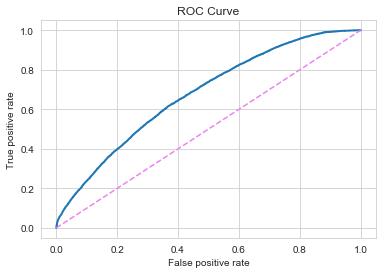

In [50]:
print(classification_report(y_val, lgb_model.predict(X_val)))
plot_ROC(X_val, y_val, lgb_model)

### Parameter Tuning with Catboost

In [53]:
booking_df_cat = booking_df.copy()
X_catboost = booking_df_cat.drop('booker', 1)
y_catboost = booking_df_cat.booker

X_catboost, X_test_catboost, y_catboost, y_test_catboost = train_test_split(X_catboost, y_catboost, test_size=0.20, random_state=42, stratify = y_catboost)
X_train_catboost, X_val_catboost, y_train_catboost, y_val_catboost = train_test_split(X_catboost, y_catboost, test_size=0.25, random_state=42, stratify = y_catboost)

booking_features = list(X_train_catboost.drop(['age', 'delta_account_created_first_activity'], 1).columns)

In [83]:
folds = 3
catboost_params = {
                    'learning_rate': [0.001, 0.01, 0.1, 1],
                    'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9],
                    'n_estimators': [100, 200, 300, 400, 500, 600]}

#run the CV
from sklearn.model_selection import RandomizedSearchCV

# Initiate KFolds - stratify ensures even distribution of target class in each fold
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state = 42)
# instantiate a model passing in param as arguments
model = CatBoostClassifier(loss_function='Logloss',
                             cat_features=booking_features, random_state = 69, verbose = False)

gridsearchCV = RandomizedSearchCV(model, catboost_params, scoring='roc_auc', cv = kf, n_iter=50, n_jobs = 1)
# fit the model using oversampled training data 
gridsearchCV.fit(X_train_catboost, y_train_catboost)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostClassifier object at 0x1a2ea66048>,
                   iid='warn', n_iter=50, n_jobs=1,
                   param_distributions={'depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                                        'l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'learning_rate': [0.001, 0.01, 0.1, 1],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=0)

In [87]:
gridsearchCV.best_params_

{'n_estimators': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 6, 'depth': 4}

In [88]:
from catboost import CatBoostClassifier

catboost_adasyn = CatBoostClassifier(iterations=500,l2_leaf_reg=6, loss_function='Logloss', 
                                     cat_features=booking_features, learning_rate=0.1, 
                                     depth= 4, random_state = 69, verbose = False)
catboost_adasyn_clf = catboost_adasyn.fit(X_train_catboost, y_train_catboost);

              precision    recall  f1-score   support

           0       0.75      0.98      0.85     22295
           1       0.62      0.07      0.13      7890

    accuracy                           0.75     30185
   macro avg       0.68      0.53      0.49     30185
weighted avg       0.72      0.75      0.66     30185

ROC AUC score =  0.6817484070467698


0.6817484070467698

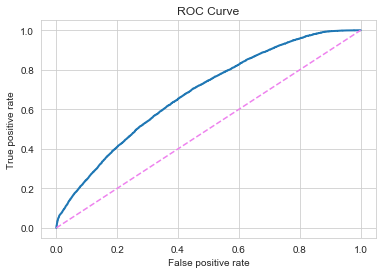

In [98]:
print(classification_report(y_val_catboost, catboost_adasyn_clf.predict(X_val_catboost)))
plot_ROC(X_val_catboost, y_val_catboost, catboost_adasyn_clf)

#### ExtraTrees Classifer

In [99]:
from sklearn.ensemble import ExtraTreesClassifier

In [103]:
folds = 3
extra_params = {'max_depth': [6, 7, 8, 9, 10, 11, 12],
                'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200],
                'max_features': ['auto', 'sqrt', 'log2']}

# model = ExtraTreesClassifier(random_state=42, n_jobs = 1, **param)
iterations = 50

#run the CV
from datetime import datetime
import random
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import ParameterGrid

# Initiate KFolds - stratify ensures even distribution of target class in each fold
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state = 42)

# initial model and score collected in each fold
model_clf_model = []
model_clf_aucs = []

# divide the training and test set into n_splits

X_train, y_train = np.array(X_train), np.array(y_train)

for train_ind, val_ind in kf.split(X_train,y_train):

    X_train_, y_train_ = X_train[train_ind], y_train[train_ind]
    X_val_, y_val_ = X_train[val_ind], y_train[val_ind] 

    # Use adasyn to oversample the training set and leave validation set alone
    X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_sample(X_train_,y_train_)

    # a dictionary of parameters to test the model on
    params = parameters

    # Make the model into a list of parameters to test on
    param_list = list(ParameterGrid(extra_params))

    # Initials a dictionary of each model and score for each param in param_list
    extra_model_aucs = {}

    # run the model for each parameter picking randomly for a number of iterations
    for param in random.sample(param_list, iterations):
        
        start_time = datetime.now()
        # instantiate a model passing in param as arguments
        model_adasyn = ExtraTreesClassifier(random_state=69, n_jobs = -1, **param)
        # fit the model using oversampled training data 
        model_adasyn.fit(X_adasyn_train, y_adasyn_train)
        end_time = datetime.now()
        duration = end_time - start_time

        # append the model and its AUC score into model_aucs which is a dictionary
        auc = roc_auc_score(y_val_, model_adasyn.predict_proba(X_val_)[:,1])
        extra_model_aucs.update({model_adasyn: auc})
        
        print(auc, param, duration)

    # append this model for to a list
    model_clf_model.append(max(extra_model_aucs, key=extra_model_aucs.get))

    # append this auc score for the model to a list
    model_clf_aucs.append(extra_model_aucs[max(extra_model_aucs, key=extra_model_aucs.get)])

0.659763567098618 {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 1200} 0:00:28.965019
0.6616964237235428 {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100} 0:00:03.010600
0.6610763400163989 {'max_depth': 7, 'max_features': 'auto', 'n_estimators': 1000} 0:00:26.990808
0.6600298424572812 {'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 600} 0:00:14.007416
0.6608763888292428 {'max_depth': 8, 'max_features': 'log2', 'n_estimators': 200} 0:00:04.692992
0.6639093062395612 {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500} 0:00:17.040356
0.6650917046819742 {'max_depth': 11, 'max_features': 'auto', 'n_estimators': 600} 0:00:21.941107
0.6655324257091786 {'max_depth': 12, 'max_features': 'auto', 'n_estimators': 500} 0:00:18.497141
0.6608807837606296 {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 500} 0:00:13.448471
0.6597465913123179 {'max_depth': 6, 'max_features': 'auto', 'n_estimators': 1000} 0:00:24.010466
0.6606948505127394 {'max_depth': 7,

In [107]:
extra_model = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
                      oob_score=False, random_state=69, verbose=0,
                      warm_start=False)
extra_model.fit(X_adasyn_train, y_adasyn_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=12, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=-1,
                     oob_score=False, random_state=69, verbose=0,
                     warm_start=False)

              precision    recall  f1-score   support

           0       0.81      0.65      0.72     27868
           1       0.37      0.58      0.45      9863

    accuracy                           0.63     37731
   macro avg       0.59      0.61      0.59     37731
weighted avg       0.70      0.63      0.65     37731

ROC AUC score =  0.663438060813073


0.663438060813073

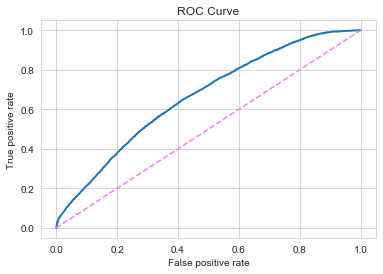

In [113]:
print(classification_report(y_val, extra_model.predict(X_val)))
plot_ROC(X_val, y_val, extra_model)

In [ ]:
plt.figure(figsize = (14,12))
for model in zip(sorted_by_AUC):

    fpr, tpr, thresholds = roc_curve(y_val, model[0][0].predict_proba(X_val)[:,1])
    plt.plot(fpr, tpr,lw=lw, label = model[0][1] + f' = {model[0][2]}')
    
fpr_xgb_adasyn, tpr_xgb_adasyn, thresholds_xgb_adasyn = roc_curve(y_val, XGBoost_adasyn_clf.predict_proba(X_val.values)[:,1])
auc_xgb_adasyn = roc_auc_score(y_val, XGBoost_adasyn_clf.predict_proba(X_val.values)[:,1])
plt.plot(fpr_xgb_adasyn, tpr_xgb_adasyn,lw=lw, label = 'XGBoost_adasyn' + f' = {round(auc_xgb_adasyn,3)}')

fpr_xgb_smoted, tpr_xgb_smoted, thresholds_xgb_smoted = roc_curve(y_val, XGBoost_smoted_clf.predict_proba(X_val.values)[:,1])
auc_xgb_smoted = roc_auc_score(y_val, XGBoost_smoted_clf.predict_proba(X_val.values)[:,1])
plt.plot(fpr_xgb_smoted, tpr_xgb_smoted,lw=lw, label = 'XGBoost_smoted' + f' = {round(auc_xgb_smoted,3)}')

# fpr_logit_adasyn, tpr_logit_adasyn, thresholds_logit_adasyn = roc_curve(y_val, logit_adasyn.predict_proba(X_val_adasyn_scaled)[:,1])
# auc_logit_adasyn = roc_auc_score(y_val, logit_adasyn.predict_proba(X_val_adasyn_scaled)[:,1])
# plt.plot(fpr_logit_adasyn, tpr_logit_adasyn,lw=lw, label = 'Logit_adasyn' + f' = {round(auc_logit_adasyn,3)}')

# fpr_logit_smoted, tpr_logit_smoted, thresholds_logit_smoted = roc_curve(y_val, logit_adasyn.predict_proba(X_val_smoted_scaled)[:,1])
# auc_logit_smoted = roc_auc_score(y_val, logit_smoted.predict_proba(X_val_smoted_scaled)[:,1])
# plt.plot(fpr_logit_smoted, tpr_logit_smoted,lw=lw, label = 'Logit_adasyn' + f' = {round(auc_logit_smoted,3)}')

# fpr_xgb_smoted, tpr_xgb_smoted, thresholds_xgb_smoted = roc_curve(y_val, XGBoost_smoted_clf.predict_proba(X_val)[:,1])
# auc_xgb_smoted = roc_auc_score(y_val, XGBoost_smoted_clf.predict_proba(X_val.values)[:,1])
# plt.plot(fpr_xgb_smoted, tpr_xgb_smoted,lw=2, label = 'XGBoost_smoted' + f' = {round(auc_xgb_smoted,3)}')

        
plt.plot([0,1],[0,1],c='violet',ls='--', lw=lw);
plt.xlim([0,1.00]);
plt.ylim([0,1.00]);
plt.xlabel('False Positive Rate', size = 20);
plt.ylabel('True Positive Rate', size = 20);
plt.title('ROC Curve', size = 25);
plt.legend(loc = 'lower right', prop={'size': 15});